### Import dependencies 

In [2]:
import pandas as pd
import numpy as np
import pickle

from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Descriptors
from rdkit.Chem import rdMolDescriptors
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw
from rdkit.Chem.Draw import rdMolDraw2D

from tensorflow.keras.models import Sequential, save_model, load_model
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow import keras
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Conv1D, MaxPooling1D, Dense, Flatten, Activation
import time
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

import seaborn as sns
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random

import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU') 

In [3]:
tf.config.list_physical_devices('GPU') 

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

### Load the dataset from the original publication

In [4]:
DF_MRI = pd.read_excel(open('ja1c08181_si_002.xlsx', 'rb'),
              sheet_name='Data organized fluoro-monomer')  

In [5]:
DF_MRI

,TFEA,HexaFOEA,NonaFOEA,PEGA,HEA,MSEA,19F NMR Signal-to-Noise Ratioa,Weight % Fluorine,Molecular weight (Mn)b,Dispersity (Ɖ)b
0,0.00,0.00,0.10,0.90,0.00,0.00,20,0.036740,-,-
1,0.00,0.00,0.20,0.30,0.00,0.50,47,0.117168,7100,1.25
2,0.00,0.00,0.20,0.30,0.50,0.00,61,0.127174,8100,1.16
3,0.00,0.00,0.20,0.40,0.00,0.40,46,0.105659,7800,1.26
4,0.00,0.00,0.20,0.40,0.40,0.00,51,0.112017,-,-
...,...,...,...,...,...,...,...,...,...,...
413,0.65,0.00,0.00,0.15,0.15,0.05,X,0.187427,-,-
414,0.70,0.00,0.00,0.30,0.00,0.00,55,0.158419,-,-
415,0.75,0.00,0.00,0.00,0.05,0.20,X,0.277993,-,-
416,0.80,0.00,0.00,0.10,0.00,0.10,X,0.243231,-,-


### Construct the summary table

In [9]:
TFEA = 'C(OC(=O)C(C[*])[*])C(F)(F)F'
HexaFOEA = 'O(C(=O)C(C[*])[*])CCOC(C(F)(F)F)C(F)(F)F'
NonaFOEA = 'O(C(=O)C(C[*])[*])CCOC(C(F)(F)F)(C(F)(F)F)C(F)(F)F'
PEGA = 'O(C(=O)C(C[*])[*])CCOC'
HEA = 'O(C(=O)C(C[*])[*])CCO[H]'
MSEA = 'O(C(=O)C(C[*])[*])CC[S](C)=O'

In [10]:
Flag = [i != 'X' for i in DF_MRI['19F NMR Signal-to-Noise Ratioa']]

In [11]:
DF_MRI[Flag]

,TFEA,HexaFOEA,NonaFOEA,PEGA,HEA,MSEA,19F NMR Signal-to-Noise Ratioa,Weight % Fluorine,Molecular weight (Mn)b,Dispersity (Ɖ)b
0,0.0,0.0,0.1,0.9,0.0,0.0,20,0.036740,-,-
1,0.0,0.0,0.2,0.3,0.0,0.5,47,0.117168,7100,1.25
2,0.0,0.0,0.2,0.3,0.5,0.0,61,0.127174,8100,1.16
3,0.0,0.0,0.2,0.4,0.0,0.4,46,0.105659,7800,1.26
4,0.0,0.0,0.2,0.4,0.4,0.0,51,0.112017,-,-
...,...,...,...,...,...,...,...,...,...,...
408,0.6,0.0,0.0,0.3,0.1,0.0,50,0.137867,4600,1.37
409,0.6,0.0,0.0,0.4,0.0,0.0,31,0.120230,-,-
410,0.6,0.0,0.0,0.4,0.0,0.0,47,0.120230,-,-
411,0.6,0.0,0.0,0.4,0.0,0.0,52,0.120230,-,-


In [12]:
Dataset_2 = DF_MRI[Flag].copy()

In [13]:
Dataset_2['Smiles'] = np.nan
for i in range(len(Dataset_2)):
    smi = 'C'
    if Dataset_2['TFEA'].iloc[i] > 0:
        smi = smi + '.C(OC(=O)C(C[*])[*])C(F)(F)F'
    if Dataset_2['HexaFOEA'].iloc[i] > 0:
        smi = smi + '.O(C(=O)C(C[*])[*])CCOC(C(F)(F)F)C(F)(F)F'
    if Dataset_2['NonaFOEA'].iloc[i] > 0:
        smi = smi + '.O(C(=O)C(C[*])[*])CCOC(C(F)(F)F)(C(F)(F)F)C(F)(F)F'
    if Dataset_2['PEGA'].iloc[i] > 0:
        smi = smi + '.O(C(=O)C(C[*])[*])CCOC'
    if Dataset_2['HEA'].iloc[i] > 0:
        smi = smi + '.O(C(=O)C(C[*])[*])CCO[H]'
    if Dataset_2['MSEA'].iloc[i] > 0:
        smi = smi + '.O(C(=O)C(C[*])[*])CC[S](C)=O'
    Dataset_2['Smiles'].iloc[i] = smi   

C:\Users\let20002\AppData\Roaming\Python\Python37\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [14]:
Dataset_2

,TFEA,HexaFOEA,NonaFOEA,PEGA,HEA,MSEA,19F NMR Signal-to-Noise Ratioa,Weight % Fluorine,Molecular weight (Mn)b,Dispersity (Ɖ)b,Smiles
0,0.0,0.0,0.1,0.9,0.0,0.0,20,0.036740,-,-,C.O(C(=O)C(C[*])[*])CCOC(C(F)(F)F)(C(F)(F)F)C(...
1,0.0,0.0,0.2,0.3,0.0,0.5,47,0.117168,7100,1.25,C.O(C(=O)C(C[*])[*])CCOC(C(F)(F)F)(C(F)(F)F)C(...
2,0.0,0.0,0.2,0.3,0.5,0.0,61,0.127174,8100,1.16,C.O(C(=O)C(C[*])[*])CCOC(C(F)(F)F)(C(F)(F)F)C(...
3,0.0,0.0,0.2,0.4,0.0,0.4,46,0.105659,7800,1.26,C.O(C(=O)C(C[*])[*])CCOC(C(F)(F)F)(C(F)(F)F)C(...
4,0.0,0.0,0.2,0.4,0.4,0.0,51,0.112017,-,-,C.O(C(=O)C(C[*])[*])CCOC(C(F)(F)F)(C(F)(F)F)C(...
...,...,...,...,...,...,...,...,...,...,...,...
408,0.6,0.0,0.0,0.3,0.1,0.0,50,0.137867,4600,1.37,C.C(OC(=O)C(C[*])[*])C(F)(F)F.O(C(=O)C(C[*])[*...
409,0.6,0.0,0.0,0.4,0.0,0.0,31,0.120230,-,-,C.C(OC(=O)C(C[*])[*])C(F)(F)F.O(C(=O)C(C[*])[*...
410,0.6,0.0,0.0,0.4,0.0,0.0,47,0.120230,-,-,C.C(OC(=O)C(C[*])[*])C(F)(F)F.O(C(=O)C(C[*])[*...
411,0.6,0.0,0.0,0.4,0.0,0.0,52,0.120230,-,-,C.C(OC(=O)C(C[*])[*])C(F)(F)F.O(C(=O)C(C[*])[*...


### Feature engineering with Morgan fingerprint

In [16]:
MOL = pd.DataFrame(['C(OC(=O)C(C[*])[*])C(F)(F)F',
'O(C(=O)C(C[*])[*])CCOC(C(F)(F)F)C(F)(F)F',
'O(C(=O)C(C[*])[*])CCOC(C(F)(F)F)(C(F)(F)F)C(F)(F)F',
'O(C(=O)C(C[*])[*])CCOC',
'O(C(=O)C(C[*])[*])CCO[H]',
'O(C(=O)C(C[*])[*])CC[S](C)=O'])[0].apply(Chem.MolFromSmiles)

In [17]:
fp_1 = MOL.apply(lambda m: AllChem.GetMorganFingerprint(m, radius=3))
fp_1_n = fp_1.apply(lambda m: m.GetNonzeroElements())

In [18]:
# using substructures in dataset-1 to construct a dictionary
HashCode = []
for i in fp_1_n:
    for j in i.keys():
        HashCode.append(j)

unique_set = set(HashCode)
unique_list = list(unique_set)

Corr_df = pd.DataFrame(unique_list).reset_index()

In [19]:
#construct dataset-1 input
MY_finger = []
for polymer in fp_1_n:
    my_finger = [0] * len(unique_list)
    for key in polymer.keys():
        index = Corr_df[Corr_df[0] == key]['index'].values[0]
        my_finger[index] = polymer[key]
    MY_finger.append(my_finger)

MY_finger_dataset = pd.DataFrame(MY_finger)  

In [20]:
MY_finger_dataset

,0,1,2,3,4,5,6,7,8,9,...,70,71,72,73,74,75,76,77,78,79
0,1,0,0,0,0,0,0,0,0,0,...,0,0,1,1,0,0,0,1,0,0
1,2,0,1,1,2,1,0,0,0,0,...,0,0,1,1,0,0,0,0,0,2
2,1,0,0,0,2,0,0,1,3,1,...,1,1,1,1,0,0,0,0,0,0
3,1,0,0,0,2,0,1,0,0,0,...,0,0,1,1,0,0,1,0,1,0
4,1,0,0,0,1,0,0,0,0,0,...,0,0,1,1,0,1,0,0,0,0
5,1,1,0,0,1,0,1,0,0,0,...,0,0,1,1,1,0,0,0,0,0


In [21]:
# filter input into the most popular 124 substructures
Zero_Sum = (MY_finger_dataset == 0).astype(int).sum()
NumberOfZero = 6
print(len(Zero_Sum[Zero_Sum < NumberOfZero]))
X = MY_finger_dataset[Zero_Sum[Zero_Sum < NumberOfZero].index]

80


### CNN

In [22]:
Mix_X_100Block = []
for i in range(len(DF_MRI[Flag])):
        random.seed(10)

        Random_position = []
        Random_position_all = []

        Rest = range(0, 100)
        for col in ['TFEA', 'HexaFOEA', 'NonaFOEA', 'PEGA', 'HEA', 'MSEA']:

            X_random_position = random.sample(Rest, int(DF_MRI[Flag][col].iloc[i] * 100))
            Random_position.append(X_random_position)
            for p in X_random_position:
                Random_position_all.append(p)
            Rest = []
            for x in range(0, 100):
                if x not in Random_position_all:
                    Rest.append(x)
        
        Sequency_X = [0 for a in range(100)]
        for j in range(100):
            if j in Random_position[0]:
                Sequency_X[j] = list(X.iloc[0].values)
            elif j in Random_position[1]:
                Sequency_X[j] = list(X.iloc[1].values)
            elif j in Random_position[2]:
                Sequency_X[j] = list(X.iloc[2].values)
            elif j in Random_position[3]:
                Sequency_X[j] = list(X.iloc[3].values)
            elif j in Random_position[4]:
                Sequency_X[j] = list(X.iloc[4].values)
            elif j in Random_position[5]:
                Sequency_X[j] = list(X.iloc[5].values)
                
        Mix_X_100Block.append(Sequency_X)   

Mix_X_100Block = np.array(Mix_X_100Block)

In [23]:
Mix_X_100Block.shape

(271, 100, 80)

In [24]:
Mix_X_100Block

array([[[1, 0, 0, ..., 0, 1, 0],
        [1, 0, 0, ..., 0, 0, 0],
        [1, 0, 0, ..., 0, 1, 0],
        ...,
        [1, 0, 0, ..., 0, 1, 0],
        [1, 0, 0, ..., 0, 1, 0],
        [1, 0, 0, ..., 0, 1, 0]],

       [[1, 0, 0, ..., 0, 1, 0],
        [1, 0, 0, ..., 0, 0, 0],
        [1, 1, 0, ..., 0, 0, 0],
        ...,
        [1, 0, 0, ..., 0, 1, 0],
        [1, 1, 0, ..., 0, 0, 0],
        [1, 0, 0, ..., 0, 1, 0]],

       [[1, 0, 0, ..., 0, 1, 0],
        [1, 0, 0, ..., 0, 0, 0],
        [1, 0, 0, ..., 0, 0, 0],
        ...,
        [1, 0, 0, ..., 0, 1, 0],
        [1, 0, 0, ..., 0, 0, 0],
        [1, 0, 0, ..., 0, 1, 0]],

       ...,

       [[1, 0, 0, ..., 1, 0, 0],
        [1, 0, 0, ..., 1, 0, 0],
        [1, 0, 0, ..., 1, 0, 0],
        ...,
        [1, 0, 0, ..., 0, 1, 0],
        [1, 0, 0, ..., 1, 0, 0],
        [1, 0, 0, ..., 1, 0, 0]],

       [[1, 0, 0, ..., 1, 0, 0],
        [1, 0, 0, ..., 1, 0, 0],
        [1, 0, 0, ..., 1, 0, 0],
        ...,
        [1, 0, 0, ..., 

In [25]:
Mix_X_100Block = Mix_X_100Block.reshape((271, 100, 80, 1))
Mix_X_100Block.shape

(271, 100, 80, 1)

In [24]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(Mix_X_100Block, DF_MRI[Flag]['19F NMR Signal-to-Noise Ratioa'].astype(np.float64), test_size=0.2, random_state=42)


In [25]:
model = Sequential()
model.add(Conv2D(8, (10, 10), activation='relu', input_shape=X_train.shape[1:]))
model.add(Conv2D(8, (4, 4), activation='relu'))
model.add(Conv2D(8, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.3))
model.add(Flatten())
model.add(Dense(1))
optimizer=keras.optimizers.Adam(lr=0.005)
model.compile(optimizer=optimizer, loss='mean_absolute_error')
Model=model.fit(x=X_train,y=y_train,epochs=200,
                batch_size=64,validation_split=0.2)

Epoch 1/200
3/3 [==============================] - 0s 89ms/step - loss: 48.2305 - val_loss: 18.3554
Epoch 2/200
3/3 [==============================] - 0s 14ms/step - loss: 18.5323 - val_loss: 15.0414
Epoch 3/200
3/3 [==============================] - 0s 17ms/step - loss: 14.1870 - val_loss: 14.4087
Epoch 4/200
3/3 [==============================] - 0s 14ms/step - loss: 15.6100 - val_loss: 14.4730
Epoch 5/200
3/3 [==============================] - 0s 15ms/step - loss: 13.3733 - val_loss: 13.3227
Epoch 6/200
3/3 [==============================] - 0s 13ms/step - loss: 12.9779 - val_loss: 12.9693
Epoch 7/200
3/3 [==============================] - 0s 13ms/step - loss: 12.3132 - val_loss: 13.1077
Epoch 8/200
3/3 [==============================] - 0s 13ms/step - loss: 11.7799 - val_loss: 11.8633
Epoch 9/200
3/3 [==============================] - 0s 13ms/step - loss: 11.3306 - val_loss: 11.8889
Epoch 10/200
3/3 [==============================] - 0s 13ms/step - loss: 13.7598 - val_loss: 12.5145

3/3 [==============================] - 0s 14ms/step - loss: 5.4735 - val_loss: 7.6398
Epoch 84/200
3/3 [==============================] - 0s 13ms/step - loss: 4.6901 - val_loss: 9.9711
Epoch 85/200
3/3 [==============================] - 0s 13ms/step - loss: 5.4338 - val_loss: 7.2070
Epoch 86/200
3/3 [==============================] - 0s 13ms/step - loss: 6.2573 - val_loss: 9.0794
Epoch 87/200
3/3 [==============================] - 0s 13ms/step - loss: 5.3943 - val_loss: 9.0021
Epoch 88/200
3/3 [==============================] - 0s 13ms/step - loss: 4.6749 - val_loss: 7.2553
Epoch 89/200
3/3 [==============================] - 0s 13ms/step - loss: 4.4371 - val_loss: 9.0652
Epoch 90/200
3/3 [==============================] - 0s 13ms/step - loss: 4.6158 - val_loss: 9.4715
Epoch 91/200
3/3 [==============================] - 0s 13ms/step - loss: 4.5483 - val_loss: 8.3877
Epoch 92/200
3/3 [==============================] - 0s 13ms/step - loss: 4.2569 - val_loss: 8.2526
Epoch 93/200
3/3 [=====

3/3 [==============================] - 0s 14ms/step - loss: 5.5647 - val_loss: 8.1772
Epoch 166/200
3/3 [==============================] - 0s 13ms/step - loss: 4.9264 - val_loss: 6.9488
Epoch 167/200
3/3 [==============================] - 0s 14ms/step - loss: 5.3037 - val_loss: 10.1795
Epoch 168/200
3/3 [==============================] - 0s 13ms/step - loss: 4.4847 - val_loss: 7.3188
Epoch 169/200
3/3 [==============================] - 0s 13ms/step - loss: 4.8384 - val_loss: 6.9065
Epoch 170/200
3/3 [==============================] - 0s 13ms/step - loss: 4.7108 - val_loss: 9.5744
Epoch 171/200
3/3 [==============================] - 0s 13ms/step - loss: 4.0485 - val_loss: 7.0515
Epoch 172/200
3/3 [==============================] - 0s 13ms/step - loss: 3.6788 - val_loss: 7.0271
Epoch 173/200
3/3 [==============================] - 0s 13ms/step - loss: 3.5563 - val_loss: 9.4218
Epoch 174/200
3/3 [==============================] - 0s 13ms/step - loss: 4.1928 - val_loss: 6.8559
Epoch 175/200

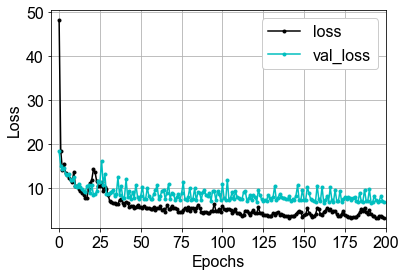

In [46]:
loss = Model.history['loss']
val_loss = Model.history['val_loss']
epochs = len(loss)
plt.xlim((-5, 200))
plt.plot(range(epochs), loss, color = 'k', marker = '.', label = 'loss')
plt.plot(range(epochs), val_loss, color = 'c', marker = '.', label = 'val_loss')
plt.xticks(fontname="Arial", fontsize=16, fontweight='normal')
plt.yticks(fontname="Arial", fontsize=16, fontweight='normal')
plt.legend(loc = 'best', framealpha=1, prop={'size': 16, 'family':"Arial"})

plt.grid()
plt.xlabel('Epochs',fontname="Arial", fontsize=16)
plt.ylabel('Loss',fontname="Arial", fontsize=16)
plt.savefig("CNN_Loss.png", dpi=600, bbox_inches='tight')
plt.show()

In [33]:
filepath = 'MRI_CNN.model'
save_model(model, filepath, save_format='h5')

In [47]:
model = load_model('MRI_CNN.model')

In [48]:
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

print("Train set R^2: %.2f" % r2_score(y_train, y_pred_train))
print("Train MAE score: %.2f" % mean_absolute_error(y_train, y_pred_train))
print("Train RMSE score: %.2f" % np.sqrt(mean_squared_error(y_train, y_pred_train)))

print("Test set R^2: %.2f" % r2_score(y_test, y_pred_test))
print("Test MAE score: %.2f" % mean_absolute_error(y_test, y_pred_test))
print("Test RMSE score: %.2f" % np.sqrt(mean_squared_error(y_test, y_pred_test)))

Train set R^2: 0.91
Train MAE score: 3.73
Train RMSE score: 6.76
Test set R^2: 0.77
Test MAE score: 8.21
Test RMSE score: 11.33


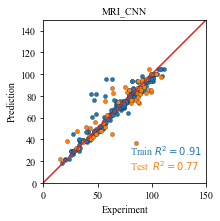

In [36]:
plt.figure(figsize=(3,3))

ax=plt.subplot(1, 1, 1)
plt.scatter(y_train, y_pred_train, c='#1f77b4', marker='o', s = 18, edgecolors='k', linewidths = 0.2)
plt.scatter(y_test, y_pred_test, c='#ff7f0e', marker='o', s = 18, edgecolors='k', linewidths = 0.2) 

plt.xlabel("Experiment",fontname="Times New Roman", fontsize=10)
plt.ylabel("Prediction",fontname="Times New Roman", fontsize=10)
x0, x1 = min(y_train), max(y_train)
length = 750
x_start, x_end = -200, 550
plt.xlim([-0, 150])
plt.ylim([-0, 150])
# ax.set_xticks([-200,-100,0,100,200,300,400,500])
# ax.set_yticks([-200,-100,0,100,200,300,400,500])
plt.xticks(fontname="Times New Roman", fontsize=10, fontweight='normal')
plt.yticks(fontname="Times New Roman", fontsize=10, fontweight='normal')
plt.gca().set_aspect("equal", adjustable="box")
# the unit line
plt.plot(np.arange(x_start, x_end, 0.01*length),
np.arange(x_start, x_end, 0.01*length), '#d62728')
plt.text(80, 25, "Train $R^2={:.2f}$".format(round(r2_score(y_train, y_pred_train),2)),{'color':'#1f77b4'}, fontname="Times New Roman", fontsize=10, fontweight='normal')
plt.text(80, 12, "Test  $R^2 ={:.2f}$".format(r2_score(y_test, y_pred_test)),{'color':'#ff7f0e'}, fontname="Times New Roman", fontsize=10, fontweight='normal')
#plt.text(80, 500, "Dataset_1")
plt.title('MRI_CNN',fontname="Times New Roman", fontsize=10)
plt.savefig("Polyinfo_MRI_CNN.png", dpi=1200, bbox_inches='tight') 

### Data Fusion

In [65]:
Mix_X = []
for i in range(len(DF_MRI[Flag])):
    Mix_X.append(X.iloc[0].values * DF_MRI[Flag]['TFEA'].iloc[i] + \
                 X.iloc[1].values * DF_MRI[Flag]['HexaFOEA'].iloc[i] + \
                 X.iloc[2].values * DF_MRI[Flag]['NonaFOEA'].iloc[i] + \
                 X.iloc[3].values * DF_MRI[Flag]['PEGA'].iloc[i] + \
                 X.iloc[4].values * DF_MRI[Flag]['HEA'].iloc[i] + \
                 X.iloc[5].values * DF_MRI[Flag]['MSEA'].iloc[i])
Mix_X = np.array(Mix_X)

In [66]:
Mix_X.shape

(271, 80)

In [67]:
Mix_X_100Block = []
for i in range(len(DF_MRI[Flag])):
        random.seed(10)

        Random_position = []
        Random_position_all = []

        Rest = range(0, 100)
        for col in ['TFEA', 'HexaFOEA', 'NonaFOEA', 'PEGA', 'HEA', 'MSEA']:

            X_random_position = random.sample(Rest, int(DF_MRI[Flag][col].iloc[i] * 100))
            Random_position.append(X_random_position)
            for p in X_random_position:
                Random_position_all.append(p)
            Rest = []
            for x in range(0, 100):
                if x not in Random_position_all:
                    Rest.append(x)
        
        Sequency_X = [0 for a in range(100)]
        for j in range(100):
            if j in Random_position[0]:
                Sequency_X[j] = 0
            elif j in Random_position[1]:
                Sequency_X[j] = 1
            elif j in Random_position[2]:
                Sequency_X[j] = 2
            elif j in Random_position[3]:
                Sequency_X[j] = 3
            elif j in Random_position[4]:
                Sequency_X[j] = 4
            elif j in Random_position[5]:
                Sequency_X[j] = 5
                
        Mix_X_100Block.append(Sequency_X)   

Mix_X_100Block = np.array(Mix_X_100Block)

In [68]:
Mix_X_100Block.shape

(271, 100)

In [69]:
Mix_X_100Block = Mix_X_100Block.reshape((271, 100, 1))
Mix_X_100Block.shape

(271, 100, 1)

In [81]:
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Flatten, LSTM, Embedding, Bidirectional, TimeDistributed, Reshape
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import Sequential, load_model
from sklearn.metrics import mean_absolute_error, r2_score
from keras.layers import Input, Dense
from keras.models import Model
from keras.utils import plot_model
from keras.layers.merge import Concatenate
from numpy.random import seed
import tensorflow

In [82]:
LSTMunits = 20

In [83]:
xtrain_B, xtest_B, ytrain_B, ytest_B=train_test_split(Mix_X, DF_MRI[Flag]['19F NMR Signal-to-Noise Ratioa'].astype(np.float64), test_size=0.20, random_state=200)
xtrain_A, xtest_A, ytrain_A, ytest_A=train_test_split(Mix_X_100Block, DF_MRI[Flag]['19F NMR Signal-to-Noise Ratioa'].astype(np.float64), test_size=0.20, random_state=200)

In [84]:
# define two sets of inputs
inputA = Input(shape=(100,1))
inputB = Input(shape=(80))

# the first branch operates on the first input
RNNmodel = Sequential()
RNNmodel.add(Bidirectional(LSTM(LSTMunits, return_sequences=True), input_shape=(100,1)))
RNNmodel.add(Bidirectional(LSTM(LSTMunits, return_sequences=True)))
RNNmodel.add(TimeDistributed(Dense(int(LSTMunits/2), activation="relu")))
RNNmodel.add(Reshape((int(LSTMunits/2*100),)))

# the second branch opreates on the second input
y = Dense(8, activation="relu")(inputB)
y = Dense(8, activation="relu")(y)
y = Model(inputs=inputB, outputs=y)
# combine the output of the two branches
combined = Concatenate()([RNNmodel.output, y.output])
# apply a FC layer and then a regression prediction on the
# combined outputs
z = Dense(8, activation="relu")(combined)
z = Dense(1, activation="linear")(z)
# our model will accept the inputs of the two branches and
# then output a single value
model = Model(inputs=[RNNmodel.input, y.input], outputs=z)

model.compile(optimizer=keras.optimizers.Adam(lr=0.001),
              loss="mean_squared_error",
              metrics=["mean_squared_error"])

Model = model.fit(
    x=[xtrain_A, xtrain_B], y=ytrain_B,
    validation_data=([xtest_A, xtest_B], ytest_B),
    epochs=300, batch_size=32, verbose=2) 

Epoch 1/300
7/7 - 1s - loss: 5208.2461 - mean_squared_error: 5208.2461 - val_loss: 5759.8066 - val_mean_squared_error: 5759.8066
Epoch 2/300
7/7 - 0s - loss: 5021.0742 - mean_squared_error: 5021.0742 - val_loss: 5443.5552 - val_mean_squared_error: 5443.5552
Epoch 3/300
7/7 - 0s - loss: 4620.5713 - mean_squared_error: 4620.5713 - val_loss: 4868.4819 - val_mean_squared_error: 4868.4819
Epoch 4/300
7/7 - 0s - loss: 3988.6692 - mean_squared_error: 3988.6692 - val_loss: 4089.0811 - val_mean_squared_error: 4089.0806
Epoch 5/300
7/7 - 0s - loss: 3195.2769 - mean_squared_error: 3195.2769 - val_loss: 3155.0369 - val_mean_squared_error: 3155.0369
Epoch 6/300
7/7 - 0s - loss: 2285.9990 - mean_squared_error: 2285.9990 - val_loss: 2139.8313 - val_mean_squared_error: 2139.8313
Epoch 7/300
7/7 - 0s - loss: 1407.1044 - mean_squared_error: 1407.1044 - val_loss: 1239.6279 - val_mean_squared_error: 1239.6279
Epoch 8/300
7/7 - 0s - loss: 761.0746 - mean_squared_error: 761.0746 - val_loss: 706.6276 - val_m

Epoch 66/300
7/7 - 0s - loss: 238.2645 - mean_squared_error: 238.2645 - val_loss: 244.9914 - val_mean_squared_error: 244.9914
Epoch 67/300
7/7 - 0s - loss: 225.0417 - mean_squared_error: 225.0417 - val_loss: 224.0595 - val_mean_squared_error: 224.0595
Epoch 68/300
7/7 - 0s - loss: 222.8687 - mean_squared_error: 222.8687 - val_loss: 222.0313 - val_mean_squared_error: 222.0313
Epoch 69/300
7/7 - 0s - loss: 227.4376 - mean_squared_error: 227.4376 - val_loss: 233.6023 - val_mean_squared_error: 233.6023
Epoch 70/300
7/7 - 0s - loss: 213.4659 - mean_squared_error: 213.4659 - val_loss: 205.4971 - val_mean_squared_error: 205.4971
Epoch 71/300
7/7 - 0s - loss: 217.7750 - mean_squared_error: 217.7750 - val_loss: 205.8771 - val_mean_squared_error: 205.8771
Epoch 72/300
7/7 - 0s - loss: 218.5381 - mean_squared_error: 218.5381 - val_loss: 217.5190 - val_mean_squared_error: 217.5190
Epoch 73/300
7/7 - 0s - loss: 210.2986 - mean_squared_error: 210.2986 - val_loss: 196.2845 - val_mean_squared_error: 1

Epoch 131/300
7/7 - 0s - loss: 193.7206 - mean_squared_error: 193.7206 - val_loss: 172.9086 - val_mean_squared_error: 172.9086
Epoch 132/300
7/7 - 0s - loss: 193.6217 - mean_squared_error: 193.6217 - val_loss: 170.4240 - val_mean_squared_error: 170.4240
Epoch 133/300
7/7 - 0s - loss: 193.6498 - mean_squared_error: 193.6498 - val_loss: 171.7392 - val_mean_squared_error: 171.7392
Epoch 134/300
7/7 - 0s - loss: 193.0299 - mean_squared_error: 193.0299 - val_loss: 169.9013 - val_mean_squared_error: 169.9013
Epoch 135/300
7/7 - 0s - loss: 193.2039 - mean_squared_error: 193.2039 - val_loss: 168.7631 - val_mean_squared_error: 168.7631
Epoch 136/300
7/7 - 0s - loss: 193.4106 - mean_squared_error: 193.4106 - val_loss: 167.9763 - val_mean_squared_error: 167.9763
Epoch 137/300
7/7 - 0s - loss: 194.5178 - mean_squared_error: 194.5178 - val_loss: 173.1034 - val_mean_squared_error: 173.1034
Epoch 138/300
7/7 - 0s - loss: 193.2886 - mean_squared_error: 193.2886 - val_loss: 167.2438 - val_mean_squared_

Epoch 196/300
7/7 - 0s - loss: 188.9266 - mean_squared_error: 188.9266 - val_loss: 160.8337 - val_mean_squared_error: 160.8337
Epoch 197/300
7/7 - 0s - loss: 189.7714 - mean_squared_error: 189.7714 - val_loss: 165.8871 - val_mean_squared_error: 165.8871
Epoch 198/300
7/7 - 0s - loss: 188.5546 - mean_squared_error: 188.5546 - val_loss: 165.0319 - val_mean_squared_error: 165.0319
Epoch 199/300
7/7 - 0s - loss: 187.6359 - mean_squared_error: 187.6359 - val_loss: 161.2424 - val_mean_squared_error: 161.2424
Epoch 200/300
7/7 - 5s - loss: 188.6706 - mean_squared_error: 188.6706 - val_loss: 164.0253 - val_mean_squared_error: 164.0253
Epoch 201/300
7/7 - 0s - loss: 187.1686 - mean_squared_error: 187.1686 - val_loss: 165.7016 - val_mean_squared_error: 165.7016
Epoch 202/300
7/7 - 0s - loss: 187.0187 - mean_squared_error: 187.0187 - val_loss: 164.9391 - val_mean_squared_error: 164.9391
Epoch 203/300
7/7 - 0s - loss: 186.6381 - mean_squared_error: 186.6381 - val_loss: 161.2207 - val_mean_squared_

Epoch 261/300
7/7 - 0s - loss: 188.7939 - mean_squared_error: 188.7939 - val_loss: 158.8738 - val_mean_squared_error: 158.8738
Epoch 262/300
7/7 - 0s - loss: 188.3050 - mean_squared_error: 188.3050 - val_loss: 172.2290 - val_mean_squared_error: 172.2290
Epoch 263/300
7/7 - 0s - loss: 190.0371 - mean_squared_error: 190.0371 - val_loss: 158.5140 - val_mean_squared_error: 158.5140
Epoch 264/300
7/7 - 0s - loss: 187.1748 - mean_squared_error: 187.1748 - val_loss: 164.4628 - val_mean_squared_error: 164.4628
Epoch 265/300
7/7 - 0s - loss: 184.5333 - mean_squared_error: 184.5333 - val_loss: 162.9624 - val_mean_squared_error: 162.9624
Epoch 266/300
7/7 - 0s - loss: 184.5030 - mean_squared_error: 184.5030 - val_loss: 163.9917 - val_mean_squared_error: 163.9917
Epoch 267/300
7/7 - 0s - loss: 182.7816 - mean_squared_error: 182.7816 - val_loss: 168.0988 - val_mean_squared_error: 168.0988
Epoch 268/300
7/7 - 0s - loss: 182.5070 - mean_squared_error: 182.5070 - val_loss: 162.9059 - val_mean_squared_

In [67]:
with open('Fusion_Loss.pickle', 'wb') as handle:
    pickle.dump(Model.history, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [50]:
Model.history = pickle.load(open("Fusion_Loss.pickle","rb"))

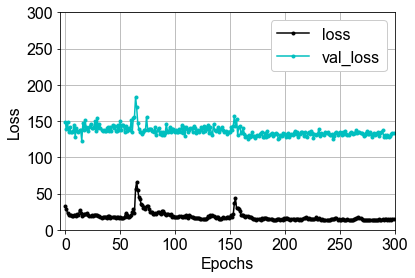

In [78]:
loss = Model.history['loss']
val_loss = Model.history['val_loss']
epochs = len(loss)
plt.xlim((-5, 300))
plt.ylim((0, 300))
plt.plot(range(epochs), loss, color = 'k', marker = '.', label = 'loss')
plt.plot(range(epochs), val_loss, color = 'c', marker = '.', label = 'val_loss')
plt.xticks(fontname="Arial", fontsize=16, fontweight='normal')
plt.yticks(fontname="Arial", fontsize=16, fontweight='normal')
plt.legend(loc = 'best', framealpha=1, prop={'size': 16, 'family':"Arial"})

plt.grid()
plt.xlabel('Epochs',fontname="Arial", fontsize=16)
plt.ylabel('Loss',fontname="Arial", fontsize=16)
plt.savefig("Fusion_Loss.png", dpi=600, bbox_inches='tight')
plt.show()

In [47]:
filepath = 'MRI_FusionModel.model'
save_model(model, filepath, save_format='h5')

In [79]:
model = load_model('MRI_FusionModel.model')

In [85]:
ytrain = ytrain_B
ytest = ytest_B

y_pred_train = model.predict([xtrain_A, xtrain_B])
print("Train set R^2: ", r2_score(ytrain, y_pred_train))

y_pred_test = model.predict([xtest_A, xtest_B])
print("Test set R^2: ", r2_score(ytest, y_pred_test))

Train set R^2:  0.6387082582620309
Test set R^2:  0.739636247230177


In [48]:
y_train = ytrain_B
y_test = ytest_B

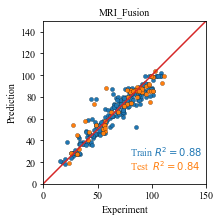

In [156]:
plt.figure(figsize=(3,3))

ax=plt.subplot(1, 1, 1)
plt.scatter(y_train, y_pred_train, c='#1f77b4', marker='o', s = 18, edgecolors='k', linewidths = 0.2)
plt.scatter(y_test, y_pred_test, c='#ff7f0e', marker='o', s = 18, edgecolors='k', linewidths = 0.2) 

plt.xlabel("Experiment",fontname="Times New Roman", fontsize=10)
plt.ylabel("Prediction",fontname="Times New Roman", fontsize=10)
x0, x1 = min(y_train), max(y_train)
length = 750
x_start, x_end = -200, 550
plt.xlim([-0, 150])
plt.ylim([-0, 150])
# ax.set_xticks([-200,-100,0,100,200,300,400,500])
# ax.set_yticks([-200,-100,0,100,200,300,400,500])
plt.xticks(fontname="Times New Roman", fontsize=10, fontweight='normal')
plt.yticks(fontname="Times New Roman", fontsize=10, fontweight='normal')
plt.gca().set_aspect("equal", adjustable="box")
# the unit line
plt.plot(np.arange(x_start, x_end, 0.01*length),
np.arange(x_start, x_end, 0.01*length), '#d62728')
plt.text(80, 25, "Train $R^2={:.2f}$".format(round(r2_score(y_train, y_pred_train),2)),{'color':'#1f77b4'}, fontname="Times New Roman", fontsize=10, fontweight='normal')
plt.text(80, 12, "Test  $R^2 ={:.2f}$".format(r2_score(y_test, y_pred_test)),{'color':'#ff7f0e'}, fontname="Times New Roman", fontsize=10, fontweight='normal')
#plt.text(80, 500, "Dataset_1")
plt.title('MRI_Fusion',fontname="Times New Roman", fontsize=10)
plt.savefig("Polyinfo_MRI_FusionModel.png", dpi=1200, bbox_inches='tight') 

### FFNN

In [80]:
Mix_X = []
for i in range(len(DF_MRI[Flag])):
    Mix_X.append(X.iloc[0].values * DF_MRI[Flag]['TFEA'].iloc[i] + \
                 X.iloc[1].values * DF_MRI[Flag]['HexaFOEA'].iloc[i] + \
                 X.iloc[2].values * DF_MRI[Flag]['NonaFOEA'].iloc[i] + \
                 X.iloc[3].values * DF_MRI[Flag]['PEGA'].iloc[i] + \
                 X.iloc[4].values * DF_MRI[Flag]['HEA'].iloc[i] + \
                 X.iloc[5].values * DF_MRI[Flag]['MSEA'].iloc[i])
Mix_X = np.array(Mix_X)

In [81]:
Mix_X.shape

(271, 80)

In [82]:
Mix_X

array([[1. , 0. , 0. , ..., 0. , 0.9, 0. ],
       [1. , 0.5, 0. , ..., 0. , 0.3, 0. ],
       [1. , 0. , 0. , ..., 0. , 0.3, 0. ],
       ...,
       [1. , 0. , 0. , ..., 0.6, 0.4, 0. ],
       [1. , 0. , 0. , ..., 0.6, 0.4, 0. ],
       [1. , 0. , 0. , ..., 0.7, 0.3, 0. ]])

In [94]:
x_train, x_test, y_train, y_test = train_test_split(Mix_X, DF_MRI[Flag]['19F NMR Signal-to-Noise Ratioa'].astype(np.float64), test_size=0.2, random_state=11)

In [95]:
model = keras.models.Sequential()
model.add(Dense(units = 24, input_dim = x_train.shape[1],activation='relu'))
model.add(Dense(units = 64, activation='relu'))
model.add(Dense(units = 1))
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001),
              loss="mean_squared_error",
              metrics=["mean_squared_error"])
Model = model.fit(x_train, y_train, epochs = 1000, batch_size = 128,
            validation_data = (x_test, y_test), verbose=2)

Epoch 1/1000
2/2 - 0s - loss: 5282.3335 - mean_squared_error: 5282.3335 - val_loss: 5533.7349 - val_mean_squared_error: 5533.7349
Epoch 2/1000
2/2 - 0s - loss: 5250.5542 - mean_squared_error: 5250.5542 - val_loss: 5500.5059 - val_mean_squared_error: 5500.5059
Epoch 3/1000
2/2 - 0s - loss: 5219.2729 - mean_squared_error: 5219.2725 - val_loss: 5467.2314 - val_mean_squared_error: 5467.2314
Epoch 4/1000
2/2 - 0s - loss: 5188.1753 - mean_squared_error: 5188.1753 - val_loss: 5431.7432 - val_mean_squared_error: 5431.7432
Epoch 5/1000
2/2 - 0s - loss: 5154.0396 - mean_squared_error: 5154.0396 - val_loss: 5394.2676 - val_mean_squared_error: 5394.2676
Epoch 6/1000
2/2 - 0s - loss: 5118.1021 - mean_squared_error: 5118.1021 - val_loss: 5354.9126 - val_mean_squared_error: 5354.9126
Epoch 7/1000
2/2 - 0s - loss: 5080.7183 - mean_squared_error: 5080.7183 - val_loss: 5312.9233 - val_mean_squared_error: 5312.9233
Epoch 8/1000
2/2 - 0s - loss: 5040.9590 - mean_squared_error: 5040.9590 - val_loss: 5268.0

Epoch 63/1000
2/2 - 0s - loss: 311.8762 - mean_squared_error: 311.8762 - val_loss: 335.7157 - val_mean_squared_error: 335.7157
Epoch 64/1000
2/2 - 0s - loss: 310.0306 - mean_squared_error: 310.0306 - val_loss: 334.1697 - val_mean_squared_error: 334.1697
Epoch 65/1000
2/2 - 0s - loss: 307.6873 - mean_squared_error: 307.6873 - val_loss: 332.4732 - val_mean_squared_error: 332.4732
Epoch 66/1000
2/2 - 0s - loss: 305.7977 - mean_squared_error: 305.7977 - val_loss: 330.6656 - val_mean_squared_error: 330.6656
Epoch 67/1000
2/2 - 0s - loss: 303.0433 - mean_squared_error: 303.0433 - val_loss: 329.0473 - val_mean_squared_error: 329.0473
Epoch 68/1000
2/2 - 0s - loss: 300.8568 - mean_squared_error: 300.8568 - val_loss: 327.5579 - val_mean_squared_error: 327.5579
Epoch 69/1000
2/2 - 0s - loss: 298.6988 - mean_squared_error: 298.6988 - val_loss: 326.2626 - val_mean_squared_error: 326.2626
Epoch 70/1000
2/2 - 0s - loss: 296.6127 - mean_squared_error: 296.6127 - val_loss: 325.1667 - val_mean_squared_

Epoch 128/1000
2/2 - 0s - loss: 241.1011 - mean_squared_error: 241.1011 - val_loss: 296.7015 - val_mean_squared_error: 296.7015
Epoch 129/1000
2/2 - 0s - loss: 240.2245 - mean_squared_error: 240.2245 - val_loss: 296.3301 - val_mean_squared_error: 296.3301
Epoch 130/1000
2/2 - 0s - loss: 239.3783 - mean_squared_error: 239.3783 - val_loss: 295.9480 - val_mean_squared_error: 295.9480
Epoch 131/1000
2/2 - 0s - loss: 238.5614 - mean_squared_error: 238.5614 - val_loss: 295.5549 - val_mean_squared_error: 295.5549
Epoch 132/1000
2/2 - 0s - loss: 237.6658 - mean_squared_error: 237.6658 - val_loss: 295.1374 - val_mean_squared_error: 295.1374
Epoch 133/1000
2/2 - 0s - loss: 236.7777 - mean_squared_error: 236.7777 - val_loss: 294.7037 - val_mean_squared_error: 294.7037
Epoch 134/1000
2/2 - 0s - loss: 235.8491 - mean_squared_error: 235.8491 - val_loss: 294.2504 - val_mean_squared_error: 294.2504
Epoch 135/1000
2/2 - 0s - loss: 234.9576 - mean_squared_error: 234.9576 - val_loss: 293.8172 - val_mean_

Epoch 193/1000
2/2 - 0s - loss: 197.1660 - mean_squared_error: 197.1660 - val_loss: 275.1034 - val_mean_squared_error: 275.1034
Epoch 194/1000
2/2 - 0s - loss: 196.6587 - mean_squared_error: 196.6587 - val_loss: 274.8774 - val_mean_squared_error: 274.8774
Epoch 195/1000
2/2 - 0s - loss: 196.3294 - mean_squared_error: 196.3294 - val_loss: 274.6760 - val_mean_squared_error: 274.6760
Epoch 196/1000
2/2 - 0s - loss: 195.9789 - mean_squared_error: 195.9789 - val_loss: 274.4880 - val_mean_squared_error: 274.4880
Epoch 197/1000
2/2 - 0s - loss: 195.5726 - mean_squared_error: 195.5726 - val_loss: 274.3154 - val_mean_squared_error: 274.3154
Epoch 198/1000
2/2 - 0s - loss: 195.2043 - mean_squared_error: 195.2043 - val_loss: 274.1096 - val_mean_squared_error: 274.1096
Epoch 199/1000
2/2 - 0s - loss: 194.8410 - mean_squared_error: 194.8410 - val_loss: 273.9811 - val_mean_squared_error: 273.9811
Epoch 200/1000
2/2 - 0s - loss: 194.4868 - mean_squared_error: 194.4868 - val_loss: 273.8354 - val_mean_

Epoch 258/1000
2/2 - 0s - loss: 181.9535 - mean_squared_error: 181.9535 - val_loss: 264.9366 - val_mean_squared_error: 264.9366
Epoch 259/1000
2/2 - 0s - loss: 181.7243 - mean_squared_error: 181.7243 - val_loss: 264.7749 - val_mean_squared_error: 264.7749
Epoch 260/1000
2/2 - 0s - loss: 181.7149 - mean_squared_error: 181.7149 - val_loss: 264.4241 - val_mean_squared_error: 264.4241
Epoch 261/1000
2/2 - 0s - loss: 181.4492 - mean_squared_error: 181.4492 - val_loss: 264.3274 - val_mean_squared_error: 264.3274
Epoch 262/1000
2/2 - 0s - loss: 181.3441 - mean_squared_error: 181.3441 - val_loss: 264.2263 - val_mean_squared_error: 264.2263
Epoch 263/1000
2/2 - 0s - loss: 181.1906 - mean_squared_error: 181.1906 - val_loss: 264.0294 - val_mean_squared_error: 264.0294
Epoch 264/1000
2/2 - 0s - loss: 181.1051 - mean_squared_error: 181.1051 - val_loss: 263.8398 - val_mean_squared_error: 263.8398
Epoch 265/1000
2/2 - 0s - loss: 180.9746 - mean_squared_error: 180.9746 - val_loss: 263.5859 - val_mean_

Epoch 323/1000
2/2 - 0s - loss: 176.2961 - mean_squared_error: 176.2961 - val_loss: 258.4753 - val_mean_squared_error: 258.4753
Epoch 324/1000
2/2 - 0s - loss: 176.2082 - mean_squared_error: 176.2082 - val_loss: 258.1956 - val_mean_squared_error: 258.1956
Epoch 325/1000
2/2 - 0s - loss: 176.1454 - mean_squared_error: 176.1454 - val_loss: 257.9991 - val_mean_squared_error: 257.9991
Epoch 326/1000
2/2 - 0s - loss: 176.1532 - mean_squared_error: 176.1532 - val_loss: 257.8984 - val_mean_squared_error: 257.8984
Epoch 327/1000
2/2 - 0s - loss: 176.0302 - mean_squared_error: 176.0302 - val_loss: 257.6057 - val_mean_squared_error: 257.6057
Epoch 328/1000
2/2 - 0s - loss: 176.0634 - mean_squared_error: 176.0634 - val_loss: 257.4678 - val_mean_squared_error: 257.4678
Epoch 329/1000
2/2 - 0s - loss: 175.9326 - mean_squared_error: 175.9326 - val_loss: 257.1986 - val_mean_squared_error: 257.1986
Epoch 330/1000
2/2 - 0s - loss: 176.0229 - mean_squared_error: 176.0229 - val_loss: 256.9893 - val_mean_

Epoch 388/1000
2/2 - 0s - loss: 173.3095 - mean_squared_error: 173.3095 - val_loss: 254.6781 - val_mean_squared_error: 254.6781
Epoch 389/1000
2/2 - 0s - loss: 173.2599 - mean_squared_error: 173.2599 - val_loss: 254.6820 - val_mean_squared_error: 254.6820
Epoch 390/1000
2/2 - 0s - loss: 173.1385 - mean_squared_error: 173.1385 - val_loss: 254.1968 - val_mean_squared_error: 254.1968
Epoch 391/1000
2/2 - 0s - loss: 173.0847 - mean_squared_error: 173.0847 - val_loss: 253.9027 - val_mean_squared_error: 253.9027
Epoch 392/1000
2/2 - 0s - loss: 172.9781 - mean_squared_error: 172.9781 - val_loss: 253.3361 - val_mean_squared_error: 253.3361
Epoch 393/1000
2/2 - 0s - loss: 172.9473 - mean_squared_error: 172.9473 - val_loss: 252.9812 - val_mean_squared_error: 252.9812
Epoch 394/1000
2/2 - 0s - loss: 173.0005 - mean_squared_error: 173.0005 - val_loss: 252.7093 - val_mean_squared_error: 252.7093
Epoch 395/1000
2/2 - 0s - loss: 173.0972 - mean_squared_error: 173.0972 - val_loss: 252.7198 - val_mean_

Epoch 453/1000
2/2 - 0s - loss: 171.1320 - mean_squared_error: 171.1320 - val_loss: 250.4198 - val_mean_squared_error: 250.4198
Epoch 454/1000
2/2 - 0s - loss: 171.1970 - mean_squared_error: 171.1970 - val_loss: 250.8000 - val_mean_squared_error: 250.8000
Epoch 455/1000
2/2 - 0s - loss: 171.0394 - mean_squared_error: 171.0394 - val_loss: 250.8542 - val_mean_squared_error: 250.8542
Epoch 456/1000
2/2 - 0s - loss: 171.0321 - mean_squared_error: 171.0321 - val_loss: 250.8918 - val_mean_squared_error: 250.8918
Epoch 457/1000
2/2 - 0s - loss: 171.1045 - mean_squared_error: 171.1045 - val_loss: 250.8880 - val_mean_squared_error: 250.8880
Epoch 458/1000
2/2 - 0s - loss: 170.9566 - mean_squared_error: 170.9566 - val_loss: 250.5242 - val_mean_squared_error: 250.5242
Epoch 459/1000
2/2 - 0s - loss: 170.9372 - mean_squared_error: 170.9372 - val_loss: 250.1592 - val_mean_squared_error: 250.1592
Epoch 460/1000
2/2 - 0s - loss: 170.9338 - mean_squared_error: 170.9338 - val_loss: 250.0019 - val_mean_

Epoch 518/1000
2/2 - 0s - loss: 169.7002 - mean_squared_error: 169.7002 - val_loss: 248.7181 - val_mean_squared_error: 248.7181
Epoch 519/1000
2/2 - 0s - loss: 169.6376 - mean_squared_error: 169.6376 - val_loss: 248.6629 - val_mean_squared_error: 248.6629
Epoch 520/1000
2/2 - 0s - loss: 169.7116 - mean_squared_error: 169.7116 - val_loss: 248.3378 - val_mean_squared_error: 248.3378
Epoch 521/1000
2/2 - 0s - loss: 169.7647 - mean_squared_error: 169.7647 - val_loss: 248.1631 - val_mean_squared_error: 248.1631
Epoch 522/1000
2/2 - 0s - loss: 169.5906 - mean_squared_error: 169.5906 - val_loss: 248.4433 - val_mean_squared_error: 248.4433
Epoch 523/1000
2/2 - 0s - loss: 169.6388 - mean_squared_error: 169.6388 - val_loss: 248.5697 - val_mean_squared_error: 248.5697
Epoch 524/1000
2/2 - 0s - loss: 169.7885 - mean_squared_error: 169.7885 - val_loss: 248.1776 - val_mean_squared_error: 248.1776
Epoch 525/1000
2/2 - 0s - loss: 169.5118 - mean_squared_error: 169.5118 - val_loss: 248.2162 - val_mean_

Epoch 583/1000
2/2 - 0s - loss: 168.6095 - mean_squared_error: 168.6095 - val_loss: 247.2584 - val_mean_squared_error: 247.2584
Epoch 584/1000
2/2 - 0s - loss: 168.6543 - mean_squared_error: 168.6543 - val_loss: 247.4249 - val_mean_squared_error: 247.4249
Epoch 585/1000
2/2 - 0s - loss: 168.6649 - mean_squared_error: 168.6649 - val_loss: 247.5340 - val_mean_squared_error: 247.5340
Epoch 586/1000
2/2 - 0s - loss: 168.7311 - mean_squared_error: 168.7311 - val_loss: 247.5982 - val_mean_squared_error: 247.5982
Epoch 587/1000
2/2 - 0s - loss: 168.6537 - mean_squared_error: 168.6537 - val_loss: 247.1740 - val_mean_squared_error: 247.1740
Epoch 588/1000
2/2 - 0s - loss: 168.6912 - mean_squared_error: 168.6912 - val_loss: 246.4219 - val_mean_squared_error: 246.4219
Epoch 589/1000
2/2 - 0s - loss: 168.5474 - mean_squared_error: 168.5474 - val_loss: 246.0902 - val_mean_squared_error: 246.0902
Epoch 590/1000
2/2 - 0s - loss: 168.4992 - mean_squared_error: 168.4992 - val_loss: 245.5890 - val_mean_

Epoch 648/1000
2/2 - 0s - loss: 167.8557 - mean_squared_error: 167.8557 - val_loss: 244.9154 - val_mean_squared_error: 244.9154
Epoch 649/1000
2/2 - 0s - loss: 168.0076 - mean_squared_error: 168.0076 - val_loss: 245.2490 - val_mean_squared_error: 245.2490
Epoch 650/1000
2/2 - 0s - loss: 167.8259 - mean_squared_error: 167.8259 - val_loss: 245.1690 - val_mean_squared_error: 245.1690
Epoch 651/1000
2/2 - 0s - loss: 167.8589 - mean_squared_error: 167.8589 - val_loss: 245.2155 - val_mean_squared_error: 245.2155
Epoch 652/1000
2/2 - 0s - loss: 167.8044 - mean_squared_error: 167.8044 - val_loss: 244.9927 - val_mean_squared_error: 244.9927
Epoch 653/1000
2/2 - 0s - loss: 167.8224 - mean_squared_error: 167.8224 - val_loss: 244.9267 - val_mean_squared_error: 244.9267
Epoch 654/1000
2/2 - 0s - loss: 167.7756 - mean_squared_error: 167.7756 - val_loss: 244.7044 - val_mean_squared_error: 244.7044
Epoch 655/1000
2/2 - 0s - loss: 167.7919 - mean_squared_error: 167.7919 - val_loss: 244.5232 - val_mean_

Epoch 713/1000
2/2 - 0s - loss: 167.3839 - mean_squared_error: 167.3839 - val_loss: 244.9234 - val_mean_squared_error: 244.9234
Epoch 714/1000
2/2 - 0s - loss: 167.3931 - mean_squared_error: 167.3931 - val_loss: 244.4915 - val_mean_squared_error: 244.4915
Epoch 715/1000
2/2 - 0s - loss: 167.2808 - mean_squared_error: 167.2808 - val_loss: 244.2898 - val_mean_squared_error: 244.2898
Epoch 716/1000
2/2 - 0s - loss: 167.2762 - mean_squared_error: 167.2762 - val_loss: 244.1466 - val_mean_squared_error: 244.1466
Epoch 717/1000
2/2 - 0s - loss: 167.2742 - mean_squared_error: 167.2742 - val_loss: 243.9405 - val_mean_squared_error: 243.9405
Epoch 718/1000
2/2 - 0s - loss: 167.2924 - mean_squared_error: 167.2924 - val_loss: 243.6089 - val_mean_squared_error: 243.6089
Epoch 719/1000
2/2 - 0s - loss: 167.2981 - mean_squared_error: 167.2981 - val_loss: 243.5117 - val_mean_squared_error: 243.5117
Epoch 720/1000
2/2 - 0s - loss: 167.3007 - mean_squared_error: 167.3007 - val_loss: 243.6613 - val_mean_

Epoch 778/1000
2/2 - 0s - loss: 166.8484 - mean_squared_error: 166.8484 - val_loss: 242.5273 - val_mean_squared_error: 242.5273
Epoch 779/1000
2/2 - 0s - loss: 166.8329 - mean_squared_error: 166.8329 - val_loss: 242.7929 - val_mean_squared_error: 242.7929
Epoch 780/1000
2/2 - 0s - loss: 166.8732 - mean_squared_error: 166.8732 - val_loss: 243.1060 - val_mean_squared_error: 243.1060
Epoch 781/1000
2/2 - 0s - loss: 166.8188 - mean_squared_error: 166.8188 - val_loss: 243.7405 - val_mean_squared_error: 243.7405
Epoch 782/1000
2/2 - 0s - loss: 166.9091 - mean_squared_error: 166.9091 - val_loss: 244.0426 - val_mean_squared_error: 244.0426
Epoch 783/1000
2/2 - 0s - loss: 167.0093 - mean_squared_error: 167.0093 - val_loss: 243.8196 - val_mean_squared_error: 243.8196
Epoch 784/1000
2/2 - 0s - loss: 166.8925 - mean_squared_error: 166.8925 - val_loss: 243.6510 - val_mean_squared_error: 243.6510
Epoch 785/1000
2/2 - 0s - loss: 166.9521 - mean_squared_error: 166.9521 - val_loss: 243.1611 - val_mean_

Epoch 843/1000
2/2 - 0s - loss: 166.5983 - mean_squared_error: 166.5983 - val_loss: 242.2780 - val_mean_squared_error: 242.2780
Epoch 844/1000
2/2 - 0s - loss: 166.5488 - mean_squared_error: 166.5488 - val_loss: 242.0598 - val_mean_squared_error: 242.0598
Epoch 845/1000
2/2 - 0s - loss: 166.5633 - mean_squared_error: 166.5633 - val_loss: 241.9825 - val_mean_squared_error: 241.9825
Epoch 846/1000
2/2 - 0s - loss: 166.5541 - mean_squared_error: 166.5541 - val_loss: 242.1050 - val_mean_squared_error: 242.1050
Epoch 847/1000
2/2 - 0s - loss: 166.5521 - mean_squared_error: 166.5521 - val_loss: 242.3732 - val_mean_squared_error: 242.3732
Epoch 848/1000
2/2 - 0s - loss: 166.4857 - mean_squared_error: 166.4857 - val_loss: 242.8830 - val_mean_squared_error: 242.8830
Epoch 849/1000
2/2 - 0s - loss: 166.5702 - mean_squared_error: 166.5702 - val_loss: 243.3698 - val_mean_squared_error: 243.3698
Epoch 850/1000
2/2 - 0s - loss: 166.6797 - mean_squared_error: 166.6797 - val_loss: 243.5046 - val_mean_

2/2 - 0s - loss: 166.3220 - mean_squared_error: 166.3220 - val_loss: 241.0941 - val_mean_squared_error: 241.0941
Epoch 908/1000
2/2 - 0s - loss: 166.2803 - mean_squared_error: 166.2803 - val_loss: 240.9373 - val_mean_squared_error: 240.9373
Epoch 909/1000
2/2 - 0s - loss: 166.6955 - mean_squared_error: 166.6955 - val_loss: 240.6071 - val_mean_squared_error: 240.6071
Epoch 910/1000
2/2 - 0s - loss: 166.3592 - mean_squared_error: 166.3592 - val_loss: 241.1118 - val_mean_squared_error: 241.1118
Epoch 911/1000
2/2 - 0s - loss: 166.3820 - mean_squared_error: 166.3820 - val_loss: 241.2419 - val_mean_squared_error: 241.2419
Epoch 912/1000
2/2 - 0s - loss: 166.2441 - mean_squared_error: 166.2441 - val_loss: 241.8203 - val_mean_squared_error: 241.8203
Epoch 913/1000
2/2 - 0s - loss: 166.3743 - mean_squared_error: 166.3743 - val_loss: 242.1218 - val_mean_squared_error: 242.1218
Epoch 914/1000
2/2 - 0s - loss: 166.3854 - mean_squared_error: 166.3854 - val_loss: 242.6855 - val_mean_squared_error: 

Epoch 972/1000
2/2 - 0s - loss: 166.1588 - mean_squared_error: 166.1588 - val_loss: 240.1647 - val_mean_squared_error: 240.1647
Epoch 973/1000
2/2 - 0s - loss: 166.0508 - mean_squared_error: 166.0508 - val_loss: 239.8613 - val_mean_squared_error: 239.8613
Epoch 974/1000
2/2 - 0s - loss: 166.4068 - mean_squared_error: 166.4068 - val_loss: 239.7059 - val_mean_squared_error: 239.7059
Epoch 975/1000
2/2 - 0s - loss: 166.0763 - mean_squared_error: 166.0763 - val_loss: 240.3069 - val_mean_squared_error: 240.3069
Epoch 976/1000
2/2 - 0s - loss: 166.0696 - mean_squared_error: 166.0696 - val_loss: 241.0609 - val_mean_squared_error: 241.0609
Epoch 977/1000
2/2 - 0s - loss: 166.5538 - mean_squared_error: 166.5538 - val_loss: 241.7390 - val_mean_squared_error: 241.7390
Epoch 978/1000
2/2 - 0s - loss: 166.0587 - mean_squared_error: 166.0587 - val_loss: 241.3145 - val_mean_squared_error: 241.3145
Epoch 979/1000
2/2 - 0s - loss: 166.0345 - mean_squared_error: 166.0345 - val_loss: 240.8235 - val_mean_

In [99]:
with open('FFNN_Loss.pickle', 'wb') as handle:
    pickle.dump(Model.history, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
Model.history = pickle.load(open("FFNN_Loss.pickle","rb"))

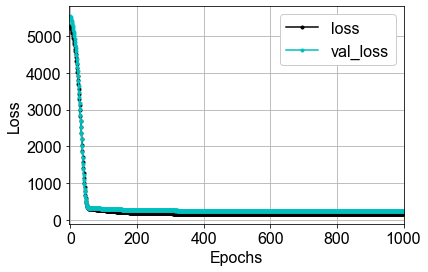

In [98]:
loss = Model.history['loss']
val_loss = Model.history['val_loss']
epochs = len(loss)
plt.xlim((-5, 1000))
plt.plot(range(epochs), loss, color = 'k', marker = '.', label = 'loss')
plt.plot(range(epochs), val_loss, color = 'c', marker = '.', label = 'val_loss')
plt.xticks(fontname="Arial", fontsize=16, fontweight='normal')
plt.yticks(fontname="Arial", fontsize=16, fontweight='normal')
plt.legend(loc = 'best', framealpha=1, prop={'size': 16, 'family':"Arial"})

plt.grid()
plt.xlabel('Epochs',fontname="Arial", fontsize=16)
plt.ylabel('Loss',fontname="Arial", fontsize=16)
plt.savefig("FFNN_Loss.png", dpi=600, bbox_inches='tight')
plt.show()

In [57]:
filepath = 'MRI_DNN.model'
save_model(model, filepath, save_format='h5')

In [58]:
model = load_model('MRI_DNN.model')

In [59]:
y_pred_train = model.predict((x_train))
print("Train set R^2: %.2f" % r2_score(y_train, y_pred_train))
print("Train MAE score: %.2f" % mean_absolute_error(y_train, y_pred_train))
print("Train RMSE score: %.2f" % np.sqrt(mean_squared_error(y_train, y_pred_train)))

y_pred_test = model.predict((x_test))
print("Test set R^2: %.2f" % r2_score(y_test, y_pred_test))
print("Test MAE score: %.2f" % mean_absolute_error(y_test, y_pred_test))
print("Test RMSE score: %.2f" % np.sqrt(mean_squared_error(y_test, y_pred_test)))

Train set R^2: 0.61
Train MAE score: 10.95
Train RMSE score: 14.21
Test set R^2: 0.71
Test MAE score: 10.37
Test RMSE score: 12.13


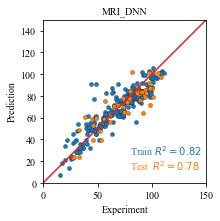

In [172]:
plt.figure(figsize=(3,3))

ax=plt.subplot(1, 1, 1)
plt.scatter(y_train, y_pred_train, c='#1f77b4', marker='o', s = 18, edgecolors='k', linewidths = 0.2)
plt.scatter(y_test, y_pred_test, c='#ff7f0e', marker='o', s = 18, edgecolors='k', linewidths = 0.2) 

plt.xlabel("Experiment",fontname="Times New Roman", fontsize=10)
plt.ylabel("Prediction",fontname="Times New Roman", fontsize=10)
x0, x1 = min(y_train), max(y_train)
length = 750
x_start, x_end = -200, 550
plt.xlim([-0, 150])
plt.ylim([-0, 150])
# ax.set_xticks([-200,-100,0,100,200,300,400,500])
# ax.set_yticks([-200,-100,0,100,200,300,400,500])
plt.xticks(fontname="Times New Roman", fontsize=10, fontweight='normal')
plt.yticks(fontname="Times New Roman", fontsize=10, fontweight='normal')
plt.gca().set_aspect("equal", adjustable="box")
# the unit line
plt.plot(np.arange(x_start, x_end, 0.01*length),
np.arange(x_start, x_end, 0.01*length), '#d62728')
plt.text(80, 25, "Train $R^2={:.2f}$".format(round(r2_score(y_train, y_pred_train),2)),{'color':'#1f77b4'}, fontname="Times New Roman", fontsize=10, fontweight='normal')
plt.text(80, 12, "Test  $R^2 ={:.2f}$".format(r2_score(y_test, y_pred_test)),{'color':'#ff7f0e'}, fontname="Times New Roman", fontsize=10, fontweight='normal')
#plt.text(80, 500, "Dataset_1")
plt.title('MRI_DNN',fontname="Times New Roman", fontsize=10)
plt.savefig("Polyinfo_MRI_DNN.png", dpi=1200, bbox_inches='tight') 

### RNN

In [26]:
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Flatten, LSTM, Embedding, Bidirectional, TimeDistributed, Reshape
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import Sequential, load_model
from sklearn.metrics import mean_absolute_error, r2_score

In [27]:
Mix_X_100Block = []
for i in range(len(DF_MRI[Flag])):
        random.seed(10)

        Random_position = []
        Random_position_all = []

        Rest = range(0, 100)
        for col in ['TFEA', 'HexaFOEA', 'NonaFOEA', 'PEGA', 'HEA', 'MSEA']:

            X_random_position = random.sample(Rest, int(DF_MRI[Flag][col].iloc[i] * 100))
            Random_position.append(X_random_position)
            for p in X_random_position:
                Random_position_all.append(p)
            Rest = []
            for x in range(0, 100):
                if x not in Random_position_all:
                    Rest.append(x)
        
        Sequency_X = [0 for a in range(100)]
        for j in range(100):
            if j in Random_position[0]:
                Sequency_X[j] = list(X.iloc[0].values)
            elif j in Random_position[1]:
                Sequency_X[j] = list(X.iloc[1].values)
            elif j in Random_position[2]:
                Sequency_X[j] = list(X.iloc[2].values)
            elif j in Random_position[3]:
                Sequency_X[j] = list(X.iloc[3].values)
            elif j in Random_position[4]:
                Sequency_X[j] = list(X.iloc[4].values)
            elif j in Random_position[5]:
                Sequency_X[j] = list(X.iloc[5].values)
                
        Mix_X_100Block.append(Sequency_X)   

Mix_X_100Block = np.array(Mix_X_100Block)

In [28]:
Mix_X_100Block.shape

(271, 100, 80)

In [29]:
Mix_X_100Block

array([[[1, 0, 0, ..., 0, 1, 0],
        [1, 0, 0, ..., 0, 0, 0],
        [1, 0, 0, ..., 0, 1, 0],
        ...,
        [1, 0, 0, ..., 0, 1, 0],
        [1, 0, 0, ..., 0, 1, 0],
        [1, 0, 0, ..., 0, 1, 0]],

       [[1, 0, 0, ..., 0, 1, 0],
        [1, 0, 0, ..., 0, 0, 0],
        [1, 1, 0, ..., 0, 0, 0],
        ...,
        [1, 0, 0, ..., 0, 1, 0],
        [1, 1, 0, ..., 0, 0, 0],
        [1, 0, 0, ..., 0, 1, 0]],

       [[1, 0, 0, ..., 0, 1, 0],
        [1, 0, 0, ..., 0, 0, 0],
        [1, 0, 0, ..., 0, 0, 0],
        ...,
        [1, 0, 0, ..., 0, 1, 0],
        [1, 0, 0, ..., 0, 0, 0],
        [1, 0, 0, ..., 0, 1, 0]],

       ...,

       [[1, 0, 0, ..., 1, 0, 0],
        [1, 0, 0, ..., 1, 0, 0],
        [1, 0, 0, ..., 1, 0, 0],
        ...,
        [1, 0, 0, ..., 0, 1, 0],
        [1, 0, 0, ..., 1, 0, 0],
        [1, 0, 0, ..., 1, 0, 0]],

       [[1, 0, 0, ..., 1, 0, 0],
        [1, 0, 0, ..., 1, 0, 0],
        [1, 0, 0, ..., 1, 0, 0],
        ...,
        [1, 0, 0, ..., 

In [30]:
X_train, X_test, y_train, y_test = train_test_split(Mix_X_100Block, DF_MRI[Flag]['19F NMR Signal-to-Noise Ratioa'].astype(np.float64), test_size=0.2, random_state=11)

In [31]:
def getRNNmodel(LSTMunits):

    RNNmodel = Sequential()
    RNNmodel.add(Bidirectional(LSTM(LSTMunits, return_sequences=True), input_shape=(100, 80)))
    RNNmodel.add(Bidirectional(LSTM(LSTMunits, return_sequences=True)))
    RNNmodel.add(TimeDistributed(Dense(int(LSTMunits/2), activation="relu")))
    RNNmodel.add(Reshape((int(LSTMunits/2*100),)))
    RNNmodel.add(Dense(1))

    return RNNmodel

LSTMunits = 20
RNNmodel = getRNNmodel(LSTMunits)
RNNmodel.compile(loss='mse', optimizer='adam', metrics=['mean_squared_error'])
Model = RNNmodel.fit(X_train, y_train, validation_split=0.2, epochs=200, \
                        batch_size=64)

Epoch 1/200
3/3 [==============================] - 1s 354ms/step - loss: 5286.1724 - mean_squared_error: 5286.1724 - val_loss: 4422.1675 - val_mean_squared_error: 4422.1675
Epoch 2/200
3/3 [==============================] - 0s 27ms/step - loss: 5158.5332 - mean_squared_error: 5158.5332 - val_loss: 4268.9771 - val_mean_squared_error: 4268.9771
Epoch 3/200
3/3 [==============================] - 0s 28ms/step - loss: 4966.3940 - mean_squared_error: 4966.3940 - val_loss: 4046.9172 - val_mean_squared_error: 4046.9172
Epoch 4/200
3/3 [==============================] - 0s 25ms/step - loss: 4695.3247 - mean_squared_error: 4695.3247 - val_loss: 3758.0354 - val_mean_squared_error: 3758.0354
Epoch 5/200
3/3 [==============================] - 0s 21ms/step - loss: 4344.3276 - mean_squared_error: 4344.3276 - val_loss: 3403.9319 - val_mean_squared_error: 3403.9319
Epoch 6/200
3/3 [==============================] - 0s 19ms/step - loss: 3929.4941 - mean_squared_error: 3929.4941 - val_loss: 3001.3474 - v

3/3 [==============================] - 0s 18ms/step - loss: 178.6454 - mean_squared_error: 178.6454 - val_loss: 248.0427 - val_mean_squared_error: 248.0427
Epoch 50/200
3/3 [==============================] - 0s 19ms/step - loss: 177.1121 - mean_squared_error: 177.1121 - val_loss: 235.7887 - val_mean_squared_error: 235.7887
Epoch 51/200
3/3 [==============================] - 0s 17ms/step - loss: 172.8555 - mean_squared_error: 172.8555 - val_loss: 238.3228 - val_mean_squared_error: 238.3228
Epoch 52/200
3/3 [==============================] - 0s 17ms/step - loss: 171.4983 - mean_squared_error: 171.4983 - val_loss: 225.7042 - val_mean_squared_error: 225.7042
Epoch 53/200
3/3 [==============================] - 0s 19ms/step - loss: 167.6052 - mean_squared_error: 167.6052 - val_loss: 221.6052 - val_mean_squared_error: 221.6052
Epoch 54/200
3/3 [==============================] - 0s 18ms/step - loss: 165.5450 - mean_squared_error: 165.5450 - val_loss: 220.2817 - val_mean_squared_error: 220.2817

3/3 [==============================] - 0s 17ms/step - loss: 141.8184 - mean_squared_error: 141.8184 - val_loss: 197.7781 - val_mean_squared_error: 197.7781
Epoch 98/200
3/3 [==============================] - 0s 18ms/step - loss: 135.6466 - mean_squared_error: 135.6466 - val_loss: 190.1340 - val_mean_squared_error: 190.1340
Epoch 99/200
3/3 [==============================] - 0s 20ms/step - loss: 130.1289 - mean_squared_error: 130.1289 - val_loss: 176.1905 - val_mean_squared_error: 176.1905
Epoch 100/200
3/3 [==============================] - 0s 20ms/step - loss: 120.5900 - mean_squared_error: 120.5900 - val_loss: 172.5301 - val_mean_squared_error: 172.5301
Epoch 101/200
3/3 [==============================] - 0s 18ms/step - loss: 124.2395 - mean_squared_error: 124.2395 - val_loss: 167.6603 - val_mean_squared_error: 167.6603
Epoch 102/200
3/3 [==============================] - 0s 16ms/step - loss: 120.5045 - mean_squared_error: 120.5045 - val_loss: 168.8144 - val_mean_squared_error: 168.8

3/3 [==============================] - 0s 17ms/step - loss: 70.3262 - mean_squared_error: 70.3262 - val_loss: 99.1707 - val_mean_squared_error: 99.1707
Epoch 146/200
3/3 [==============================] - 0s 20ms/step - loss: 71.4968 - mean_squared_error: 71.4968 - val_loss: 96.7546 - val_mean_squared_error: 96.7546
Epoch 147/200
3/3 [==============================] - 0s 18ms/step - loss: 69.8928 - mean_squared_error: 69.8928 - val_loss: 99.3704 - val_mean_squared_error: 99.3704
Epoch 148/200
3/3 [==============================] - 0s 18ms/step - loss: 67.8156 - mean_squared_error: 67.8156 - val_loss: 101.4706 - val_mean_squared_error: 101.4706
Epoch 149/200
3/3 [==============================] - 0s 15ms/step - loss: 69.4605 - mean_squared_error: 69.4605 - val_loss: 98.2826 - val_mean_squared_error: 98.2826
Epoch 150/200
3/3 [==============================] - 0s 18ms/step - loss: 72.9770 - mean_squared_error: 72.9770 - val_loss: 111.1924 - val_mean_squared_error: 111.1924
Epoch 151/200


Epoch 194/200
3/3 [==============================] - 0s 17ms/step - loss: 45.5712 - mean_squared_error: 45.5712 - val_loss: 111.3853 - val_mean_squared_error: 111.3853
Epoch 195/200
3/3 [==============================] - 0s 20ms/step - loss: 47.0450 - mean_squared_error: 47.0450 - val_loss: 108.3538 - val_mean_squared_error: 108.3538
Epoch 196/200
3/3 [==============================] - 0s 18ms/step - loss: 45.6225 - mean_squared_error: 45.6225 - val_loss: 102.6572 - val_mean_squared_error: 102.6572
Epoch 197/200
3/3 [==============================] - 0s 14ms/step - loss: 42.6936 - mean_squared_error: 42.6936 - val_loss: 105.4561 - val_mean_squared_error: 105.4561
Epoch 198/200
3/3 [==============================] - 0s 17ms/step - loss: 42.9776 - mean_squared_error: 42.9776 - val_loss: 105.2836 - val_mean_squared_error: 105.2836
Epoch 199/200
3/3 [==============================] - 0s 17ms/step - loss: 42.4914 - mean_squared_error: 42.4914 - val_loss: 100.6890 - val_mean_squared_error: 1

In [109]:
with open('RNN_Loss.pickle', 'wb') as handle:
    pickle.dump(Model.history, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
Model.history = pickle.load(open("RNN_Loss.pickle","rb"))

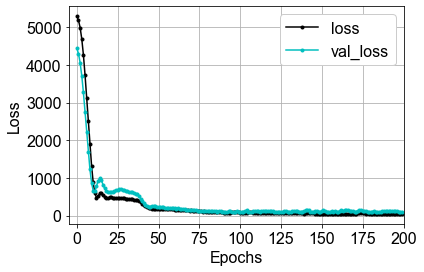

In [108]:
loss = Model.history['loss']
val_loss = Model.history['val_loss']
epochs = len(loss)
plt.xlim((-5, 200))
plt.plot(range(epochs), loss, color = 'k', marker = '.', label = 'loss')
plt.plot(range(epochs), val_loss, color = 'c', marker = '.', label = 'val_loss')
plt.xticks(fontname="Arial", fontsize=16, fontweight='normal')
plt.yticks(fontname="Arial", fontsize=16, fontweight='normal')
plt.legend(loc = 'best', framealpha=1, prop={'size': 16, 'family':"Arial"})

plt.grid()
plt.xlabel('Epochs',fontname="Arial", fontsize=16)
plt.ylabel('Loss',fontname="Arial", fontsize=16)
plt.savefig("RNN_Loss.png", dpi=600, bbox_inches='tight')
plt.show()

In [209]:
filepath = 'MRI_RNN.model'
save_model(RNNmodel, filepath, save_format='h5')

In [32]:
RNNmodel = load_model('MRI_RNN.model')

In [33]:
y_pred_train = RNNmodel.predict((X_train))
print("Train set R^2: %.2f" % r2_score(y_train, y_pred_train))
print("Train MAE score: %.2f" % mean_absolute_error(y_train, y_pred_train))
print("Train RMSE score: %.2f" % np.sqrt(mean_squared_error(y_train, y_pred_train)))

y_pred_test = RNNmodel.predict((X_test))
print("Test set R^2: %.2f" % r2_score(y_test, y_pred_test))
print("Test MAE score: %.2f" % mean_absolute_error(y_test, y_pred_test))
print("Test RMSE score: %.2f" % np.sqrt(mean_squared_error(y_test, y_pred_test)))

Train set R^2: 0.92
Train MAE score: 4.15
Train RMSE score: 6.37
Test set R^2: 0.84
Test MAE score: 7.34
Test RMSE score: 9.11


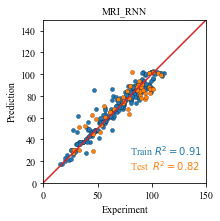

In [142]:
plt.figure(figsize=(3,3))

ax=plt.subplot(1, 1, 1)
plt.scatter(y_train, y_pred_train, c='#1f77b4', marker='o', s = 18, edgecolors='k', linewidths = 0.2)
plt.scatter(y_test, y_pred_test, c='#ff7f0e', marker='o', s = 18, edgecolors='k', linewidths = 0.2) 

plt.xlabel("Experiment",fontname="Times New Roman", fontsize=10)
plt.ylabel("Prediction",fontname="Times New Roman", fontsize=10)
x0, x1 = min(y_train), max(y_train)
length = 750
x_start, x_end = -200, 550
plt.xlim([-0, 150])
plt.ylim([-0, 150])
# ax.set_xticks([-200,-100,0,100,200,300,400,500])
# ax.set_yticks([-200,-100,0,100,200,300,400,500])
plt.xticks(fontname="Times New Roman", fontsize=10, fontweight='normal')
plt.yticks(fontname="Times New Roman", fontsize=10, fontweight='normal')
plt.gca().set_aspect("equal", adjustable="box")
# the unit line
plt.plot(np.arange(x_start, x_end, 0.01*length),
np.arange(x_start, x_end, 0.01*length), '#d62728')
plt.text(80, 25, "Train $R^2={:.2f}$".format(round(r2_score(y_train, y_pred_train),2)),{'color':'#1f77b4'}, fontname="Times New Roman", fontsize=10, fontweight='normal')
plt.text(80, 12, "Test  $R^2 ={:.2f}$".format(r2_score(y_test, y_pred_test)),{'color':'#ff7f0e'}, fontname="Times New Roman", fontsize=10, fontweight='normal')
#plt.text(80, 500, "Dataset_1")
plt.title('MRI_RNN',fontname="Times New Roman", fontsize=10)
plt.savefig("Polyinfo_MRI_RNN.png", dpi=1200, bbox_inches='tight') 